In [1]:
cd /Users/emilyvincett/Downloads/ThinkStats2-master/code

/Users/emilyvincett/Downloads/ThinkStats2-master/code


In [108]:
import pandas as pd
import numpy as np 
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smtsa
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import ttest_1samp,ttest_ind,wilcoxon,shapiro
import seaborn as sns
import thinkstats2
import thinkplot
import datetime
import regression
import timeseries
import warnings 
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=DeprecationWarning)

# Read requisite files into program

In [109]:
# The data being analysed is campaign data from Facebook's Ad Manager
# Data : Delivery of campaign by day/month

data = pd.read_csv('/Users/emilyvincett/Downloads/Daily (1).csv')

In [110]:
# Renaming columns and dropping unccessary columns across all files

data.rename({'Campaign Name':'Campaign','Amount Spent (GBP)':'Amount',
            'Landing Page Views':'LandingPageViews',
            'Cost per Landing Page View':'CPLPV',
            'Cost per Purchase':'CPP'},axis=1,inplace=True)
data.drop(['Reporting Starts','Reporting Ends'],axis=1,inplace=True)

In [111]:
# The correlation data shows a negative relationship btw Cost per purchase and Purchases
# Which makes sense the more expensive each purchase the more of my budget is spent searching for customers
# Cost per purchase is strongly positively correlated with Cost per 1000 Impressions
# The more expensive the Impressions, the higher my Cost per purchases.
# Cheaper impressions, lead to more reach, which increases landing page views, reducing the cost for each 
# landing page view and cost per purchase ========> More Purchases

# Cheaper(Impressions + Reach) + More(Landing Page Views) - (Cost Per Landing Page Views) - (Cost Per Purchase)
# ========>> More(Purchases)

#### Is there a material difference between the Purchases when CPM (cost per 1000 impressions) cost above and
## below £10.

In [112]:
# Fill null values with 0. 
data['Purchases'].fillna(0,inplace=True)

# Create a new column to represent the cost per 1000 impressions
data['C1000IMP'] = (data['Amount']/data['Impressions'])*1000

# Use boolean logic to divide the dataset into 2 cost groups.
# i.e. High = above £10 cost per 1000 impression and Low if otherwise
data['Cost'] = np.where(data['C1000IMP']<10,'Low','High')

# Filter dataset by only winning campaings

In [113]:
# Only 6 Campaigns have generated Purchases to calculate on
# Assess difference between these groups 

selected_campaigns = data[data['Purchases']>0]['Campaign'].drop_duplicates()

df = pd.DataFrame()

for a in selected_campaigns:
    df = df.append(data[data['Campaign']==a])

s = df.groupby('Campaign')['C1000IMP'].mean().sort_values(ascending=False).index
for a in enumerate(s):
    df.replace(a[1],a[0],inplace=True)
df['Campaign']+=1


print('The filtered dataset contains only %d rows,%d columns\nIts not a large enough dataset to draw meaningful inference from but ill proceed'%(df.shape))

The filtered dataset contains only 25 rows,13 columns
Its not a large enough dataset to draw meaningful inference from but ill proceed


In [114]:
# Divide the dataframe into a high cost per 1000 impression group and 
# a low cost per 1000 impression group
high = df[df['Cost']=='High']
low = df[df['Cost']=='Low']
high.shape,low.shape

((7, 13), (18, 13))

In [115]:
# When data is restricted only to campaigns that yielded Purchases the CPM's become normally distributed
# evidenced by the results of the shapiro wilks test below.

costs = df['C1000IMP']
stats, p = shapiro(costs)
print('Statistic: %.4f, P value: %.4f'%(stats,p))

if p > 0.05:
    print('The data is Normal')
else:
    print('The data is not Normal')
    
# Since the data is normal I will attempt parametric modelling via linear regression to 
# see if i can accurately predict CPM's

Statistic: 0.9672, P value: 0.5744
The data is Normal


# Visualising the C1000IMP 

0.13306427733007126

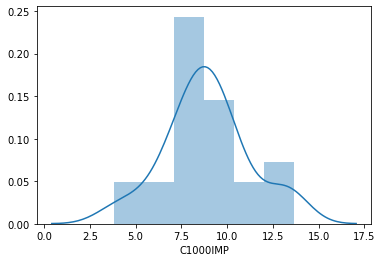

In [116]:
sns.distplot(df['C1000IMP'])
df['C1000IMP'].skew()

# The eyetest suggest a normal distribution of the data.

In [117]:
# First test the strength of mean difference between each of high and low vs the overall dataset
# We can use a ttest here because our data is normally distributed

stats, p = scipy.stats.ttest_1samp(high['C1000IMP'],df['C1000IMP'].mean())
print('1 Sample High Cost Group\nStatistics: %.3f, P: %.3f'%(stats, p))
print()
stats2, p2 = scipy.stats.ttest_1samp(low['C1000IMP'],df['C1000IMP'].mean())
print('1 Sample Low Cost Group\nStatistics: %.3f, P: %.3f'%(stats2, p2))
stats3,p3 = scipy.stats.ttest_ind(low['C1000IMP'],high['C1000IMP'])
print()
print('2 Sample Comparison Group\nStatistics: %.3f, P: %.3f'%(stats3, p3))
print()

# Both high and low cost groups show a difference to the overall dataset.
# But show an even greater difference with to each other.

1 Sample High Cost Group
Statistics: 4.671, P: 0.003

1 Sample Low Cost Group
Statistics: -2.860, P: 0.011

2 Sample Comparison Group
Statistics: -5.430, P: 0.000



In [118]:
# Function to calculate the Root Mean Square Error of my soon to be built model
# of the Cost per 1000 impressions
actual = df['C1000IMP']
def RMSE(estimates, actual):
    error = [(estimate - actual)**2 for estimate in estimates]
    e = np.mean(error)
    return np.sqrt(e)

# Normal Model Of Impression Costs

The normally distributed analytic model fits the data quite well
RMSE XBAR: 0.882698
RMSE Medians: 0.882698


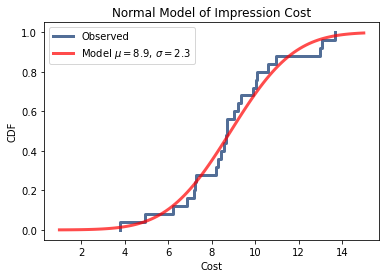

In [136]:
cdf = thinkstats2.Cdf(df['C1000IMP'])
thinkplot.Cdf(cdf,label='Observed')

mean,var = thinkstats2.MeanVar(df['C1000IMP'])
std = np.sqrt(var)
m1 = []
m2 = []

xs, ps = thinkstats2.RenderNormalCdf(mean,std,low=1,high=15)
means = xs.mean()
m1.append(means)
medians = thinkstats2.Median(xs)
m2.append(medians)
label = 'Model $\mu=%.2g$, $\sigma=%.2g$' %(mean, std)
thinkplot.Plot(xs,ps,color='r',label=label)
thinkplot.Config(title='Normal Model of Impression Cost',xlabel='Cost',ylabel='CDF')
print('The normally distributed analytic model fits the data quite well\nRMSE XBAR: %f'%(RMSE(m1,mean)))
print('RMSE Medians: %f' %(RMSE(m2,mean)))

In [120]:
# Because the analytic model fit the data well, i'll use a linear regressions model 
# to try to predict cost per 1000 impression using a range of predictors. 
# The code below builds multiple models with each input variable and Campaign to determine
# explained variance in each. 
# The results are stored in the list variances.

variances = []

for name in df.columns:
    try:
        formula = 'C1000IMP ~ Campaign+' +name
        model = smf.ols(formula,data=df)
        results = model.fit()
    except (ValueError,TypeError):
        continue
    variances.append((results.rsquared,name))  
    
variances.sort(reverse=True)
variances[2:]

[(0.725071385687049, 'Cost'),
 (0.6335843145487299, 'CPP'),
 (0.5794068730411022, 'Impressions'),
 (0.5715857283362343, 'Reach'),
 (0.5414009084733614, 'LandingPageViews'),
 (0.5308350444959209, 'CPLPV'),
 (0.5220468776188413, 'Frequency'),
 (0.5193522572516128, 'Amount'),
 (0.5185845075348827, 'Purchases'),
 (0.5183882911533195, 'Currency'),
 (0.5183882911533195, 'Campaign')]

In [121]:
# The model suggests that limiting the frequency with which ads are show to under 1.5 
# Amount spent under 10 in any day
# Choosing the right campaigns would help in targeting stable cost per 1000 impressions. 
# I think it also speak more to the market demand for the product, i.e the product lacks scalability.
# As more money spent in any 24 hour window might be grossly unprofitable

formula = 'C1000IMP ~ Amount<10  + Campaign + Frequency>1 + Frequency<1.5' 
model = smf.ols(formula,data=df) 
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               C1000IMP   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     15.91
Date:                Sat, 20 Mar 2021   Prob (F-statistic):           1.26e-05
Time:                        17:40:32   Log-Likelihood:                -41.314
No. Observations:                  25   AIC:                             90.63
Df Residuals:                      21   BIC:                             95.50
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.8325      0.810     10.900      0.000       7.147      10.518
Amount < 10[T.True]        -2.4248      1.003     -2.419      0.025      -4.510      -0.340
Frequency > 1[T.True]      -4.2730      1.459     -2.929      0.008      -7.307      -1.239
Frequency < 1.5[T.True]     8.8325      0.810     10.900      0.000       7.147      10.518
Campaign                   -0.7859      0.237     -3.316      0.003      -1.279      -0.293
==============================================================================
Omnibus:                        0.721   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.697   Jarque-Bera (JB):                0.681
Skew:                          -0.003   Prob(JB):                        0.711
Kurtosis:                       2.191   Cond. No.                     1.48e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.79e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# TimeSeries on Data

In [122]:
def GroupByDay(data,func=np.mean):
    grouped = data[['Day','C1000IMP']].groupby('Day')
    daily = grouped.aggregate(func)
    daily['Days'] = daily.index
    daily.sort_values(by='Days')
    daily['Days'] = pd.to_datetime(daily['Days'])
    start = pd.to_datetime(daily['Days'][0])

    one_month = np.timedelta64(1,'M')
    daily['Months'] = (daily['Days'] - start)/one_month
    return daily

def GroupByCostAndDay(data):
    groups = data.groupby('Cost')
    dailies = {}

    for day,cost in groups:
        dailies[day] = GroupByDay(cost)
    return dailies  

/Users/emilyvincett/Downloads/ThinkStats2-master/code/thinkplot.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  return plt.subplot(rows, cols, plot_number, **options)


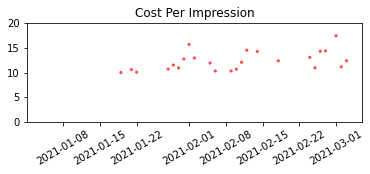

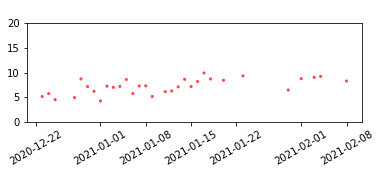

In [123]:
day = GroupByDay(data)
dailies = GroupByCostAndDay(data)

thinkplot.PrePlot(rows=2)
for i, (cost,info) in enumerate(dailies.items()):
    thinkplot.SubPlot(i+1)
    title = 'Cost Per Impression' if i==0 else' '
    thinkplot.Config(ylim=[0,20],title=title)
    thinkplot.Scatter(info['Days'],info['C1000IMP'],color='red',alpha=0.7,s=10,label=cost)
    plt.xticks(rotation=30)
    #thinkplot.Config(xticks=[])
    plt.show()

# Moving Averages

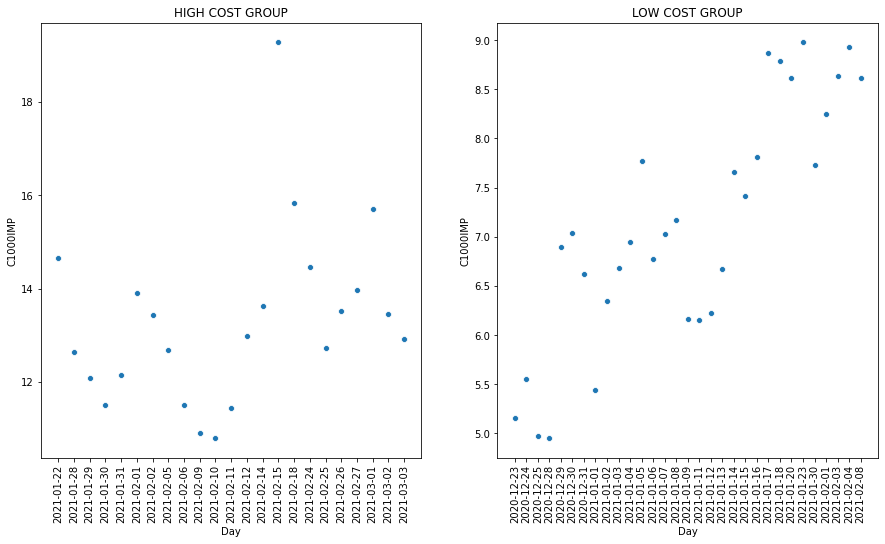

The Low Cost Group displays a linear relationship, as days go by the average costs increases
The High Cost Group seems completely random


In [127]:
high = dailies['High']['C1000IMP']
low = dailies['Low']['C1000IMP']

# Calculate the moving average of the high and low cost group
mov_avg_h = high.rolling(3).mean()
mov_avg_l = low.rolling(3).mean()

#Calculate epxonential moving averages for both 
emov_avg_h = pd.DataFrame.ewm(high,span=3).mean()
emov_avg_l = pd.DataFrame.ewm(low,span=3).mean()

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('HIGH COST GROUP')
sns.scatterplot(emov_avg_h.index[4:],emov_avg_h[4:])
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title('LOW COST GROUP')
sns.scatterplot(emov_avg_l.index,emov_avg_l)
plt.xticks(rotation=90)
plt.show()

print("The Low Cost Group displays a linear relationship, as days go by the average costs increases\nThe High Cost Group seems completely random")
# Does this mean that my impression costs will rise the longer the campaigns run for.
# Should campaigns be run for shorterperiods of time. 

# Serial Correlation

In [128]:
def SerialCorr(series,lag=3):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs,ys)
    return corr

In [129]:
corr_h = SerialCorr(high)
corr_l = SerialCorr(low)
corr_a = SerialCorr(day['C1000IMP'])
print('High Group Serial Correlation: %.5f\nLow Group Serial Correlation: %.5f\nCombined Correlation: %.5f'%(corr_h,corr_l,corr_a))

High Group Serial Correlation: -0.21732
Low Group Serial Correlation: 0.32773
Combined Correlation: 0.07302


# AutoCorrelation

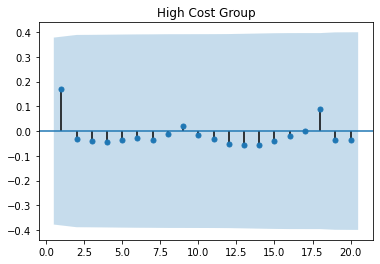

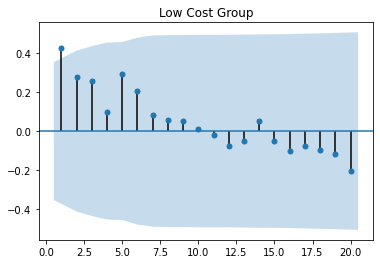

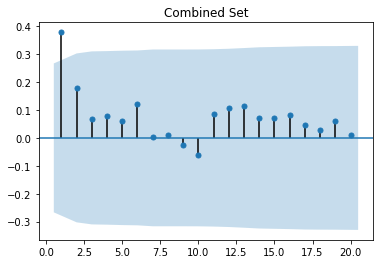

In [133]:
# 0.05% i.e. 95% Confidence Intervals
resids = [high,low,day['C1000IMP']]
for a in enumerate(resids):
    sm.graphics.tsa.plot_acf(a[1].values.squeeze(),lags=20,alpha=0.05,zero=False)
    if a[0]==0:
        plt.title('High Cost Group')
    elif a[0]==1:
        plt.title('Low Cost Group') 
    else:
        plt.title('Combined Set') 

# Conclusions

In [ ]:
# The autocorrelations shows serial correlation for the low cost and combined group.
# Any correlation doesnt seem to be statistically significant after 2 lags. 
# Which would leave me to reserve much judgment as this analysis has been conducted on a very small dataset.